<a href="https://colab.research.google.com/github/UMB200/pytorch_projects/blob/main/08_PyTorch_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.8 PyTorch Paper Replicating

In [11]:
#!rm -rf /content/modular_helpers
#!rm -rf /content/helpers

#print(os.listdir("/content/helpers"))

## 0.0 Import neessary libraries

In [12]:
import torch, torchvision, os, zipfile, random, requests, sys

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
from timeit import default_timer as timer
import tqdm.auto as tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

try:
  from torchinfo import summary
except:
  print("No torchinfo found, downloading")
  !pip install -q torchinfo
  from torchinfo import summary


if not os.path.exists('/content/helpers'):
  os.makedirs('/content/helpers')
  sys.path.insert(0, '/content/helpers')
helpers = Path('/content/helpers')


try:
  from helpers import predict, data_setup, set_rand_seed, download_data, engine, utils
except:
  print("No helper scripts are found, downloading")
  !git clone https://github.com/UMB200/pytorch_projects.git
  if not os.path.exists('/content/modular_helpers'):
    !mkdir /content/modular_helpers
  !mv /content/pytorch_projects/modular_helpers/* /content/modular_helpers
  sys.path.insert(0, '/content/modular_helpers')
  print(f"Removing extra stuff from: {helpers}")
  !rm -rf /content/pytorch_projects
  !mv /content/modular_helpers/* /content/helpers
  !rm -rf /content/modular_helpers
  sys.path.insert(0, '/content/helpers')

  from helpers import predict, data_setup, set_rand_seed, download_data, engine, utils

In [13]:
# def plot_loss_curves(results):
#   """Plots training curves of a results dictionary.

#   Args:
#     results: dictionary
#     results (dict): dictionary containing list of values, e.g.
#             {"train_loss": [...],
#              "train_acc": [...],
#              "test_loss": [...],
#              "test_acc": [...]}
#   """
#   loss_results = results["train_loss"]
#   test_loss_results = results["test_loss"]

#   accuracy_results = results["train_acc"]
#   test_accuracy_results = results["test_acc"]

#   epochs = range(len(results["train_loss"]))
#   plt.figure(figsize=(15, 7))

#   # Plot loss
#   plt.subplot(1, 2, 1)
#   plt.plot(epochs, loss_results, label="train_loss")
#   plt.plot(epochs, test_loss_results, label="test_loss")
#   plt.title("Loss")
#   plt.xlabel("Epochs")
#   plt.legend()

#   # Plot accuracy
#   plt.subplot(1, 2, 2)
#   plt.plot(epochs, accuracy_results, label="train_accuracy")
#   plt.plot(epochs, test_accuracy_results, label="test_accuracy")
#   plt.title("Accuracy")
#   plt.xlabel("Epochs")
#   plt.legend()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1.0 Get Data

In [15]:
data_path = download_data.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi")
train_dir = data_path / "train"
test_dir = data_path / "test"

No data/pizza_steak_sushi dir is found, creating one


## 2.0 Create datasets & dataloaders

### 2.1 Prep transformations for images

In [16]:
BATCH_SIZE = 32
IMG_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

### 2.2 Create dataloaders

In [17]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE)

### 2.3 Visualize single image

In [18]:
img_batch, lbl_batch = next(iter(train_dataloader))
img, lbl = img_batch[0], lbl_batch[0]
print(f"Image shape: {img.shape}")
print(f"Label shape: {lbl.shape}")

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

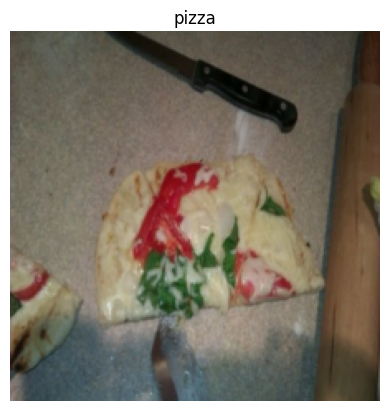

In [19]:
# show the image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[lbl])
plt.axis('off')

## 3.0 Replicating ViT: Overview

## 4.0 Equation 1

### 4.1 Calculating patch embedding input and output shapes by hand

In [20]:
#Example value
height = IMG_SIZE
width = IMG_SIZE
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches: {number_of_patches}")

Number of patches: 196


In [21]:
#Input shape
embedding_layer_input_shape = (height, width, color_channels)
print(f"Input shape: {embedding_layer_input_shape}")
#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)
print(f"Output shape: {embedding_layer_output_shape}")

Input shape: (224, 224, 3)
Output shape: (196, 768)


### 4.2 Turning a single image into patches

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

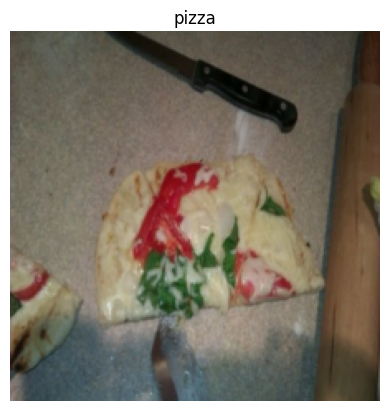

In [22]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[lbl])
plt.axis('off')

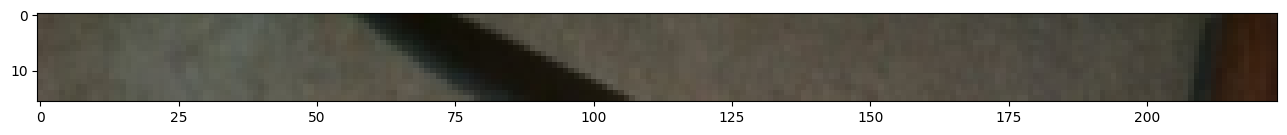

In [23]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
img_permuted = img.permute(1, 2, 0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permuted[:patch_size, :, :])
#plt.axis('off')

Number of patches per row: 14
 Patch size: 16


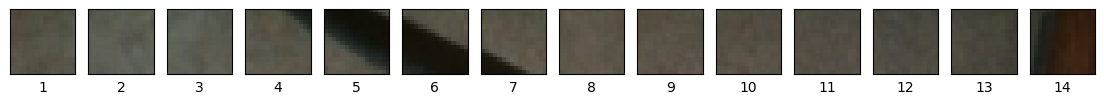

In [24]:
# create patches
patches_per_row = IMG_SIZE // patch_size
assert IMG_SIZE % patch_size == 0, f"Image size ({IMG_SIZE}) must be divisible by patch size ({patch_size})"
print(f"Number of patches per row: {patches_per_row}\n Patch size: {patch_size}")

# Show patches
fig, axes = plt.subplots(nrows=1,
                         ncols=patches_per_row,
                         figsize=(patches_per_row, patches_per_row),
                         sharex=True,
                         sharey=True)
# loop through patches
for i, patch in enumerate(range(0, IMG_SIZE, patch_size)):
  axes[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])


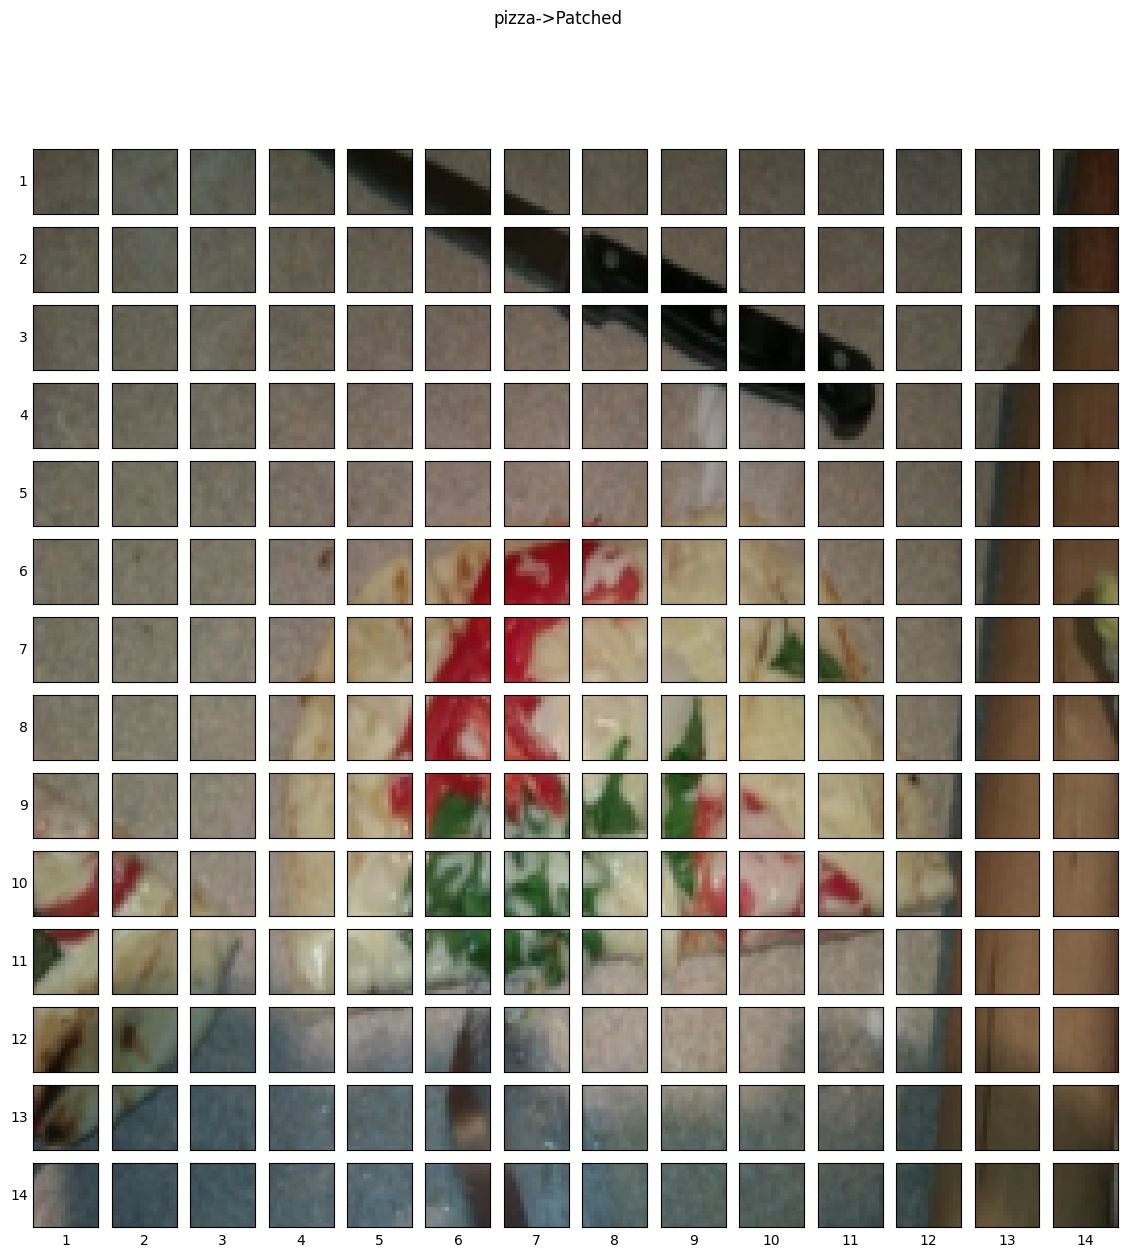

In [25]:
# Show one image vertically and horizontally in patches
fig_one_img, axes_one_img = plt.subplots(nrows=patches_per_row,
                         ncols=patches_per_row,
                         figsize=(patches_per_row, patches_per_row),
                         sharex=True,
                         sharey=True)

for i, patch_height in enumerate(range(0, IMG_SIZE, patch_size)):
  for j, patch_width in enumerate(range(0, IMG_SIZE, patch_size)):
    axes_one_img[i, j].imshow(img_permuted[patch_height:patch_height+patch_size,
                                           patch_width:patch_width+patch_size, :])
    axes_one_img[i, j].set_ylabel(i+1,
                                  rotation="horizontal",
                                  horizontalalignment="right",
                                  verticalalignment="center")
    axes_one_img[i, j].set_xlabel(j+1)
    axes_one_img[i, j].set_xticks([])
    axes_one_img[i, j].set_yticks([])
    axes_one_img[i, j].label_outer()
# Set title
fig_one_img.suptitle(f"{class_names[lbl]}->Patched", fontsize=12)
plt.show()

### 4.3 Creating image patches with `torch.nn.Conv2d()`

In [26]:
# Create convd2d layer
conv2d_layer = nn.Conv2d(in_channels=3,
                       out_channels=768,
                       kernel_size=patch_size,
                       stride=patch_size,
                       padding=0)
conv2d_layer

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

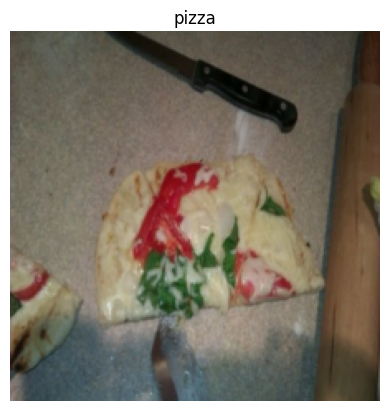

In [27]:
#pick random image and show it
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[lbl])
plt.axis('off')

In [28]:
# Pass the image through the convolutional layer
img_out_of_conv2d = conv2d_layer(img.unsqueeze(dim=0))
img_out_of_conv2d.shape

torch.Size([1, 768, 14, 14])

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Random convolutional features maps from indexes: [578, 458, 249, 109, 693]


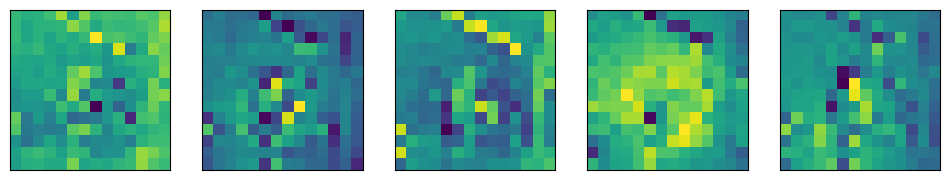

In [29]:
# Show random 5 convolutional features map
rnd_idx = random.sample(range(0, 758), k=5)
print(f"Random convolutional features maps from indexes: {rnd_idx}")
fig_rnd, axes_rnd = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Show feature maps pf random image
for i, idx in enumerate(rnd_idx):
  img_out_of_conv2d_map = img_out_of_conv2d[:, idx, :, :]
  axes_rnd[i].imshow(img_out_of_conv2d_map.squeeze().detach().numpy())
  axes_rnd[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 4.4 Flattening the patch embedding with torch.nn.Flatten

In [30]:
img_out_of_conv2d_flatten = nn.Flatten(start_dim=2, end_dim=3)(img_out_of_conv2d)
img_out_of_conv2d_flatten.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image shape after conv2d layer: torch.Size([1, 768, 14, 14])
Image shape after flattening: torch.Size([1, 768, 196])


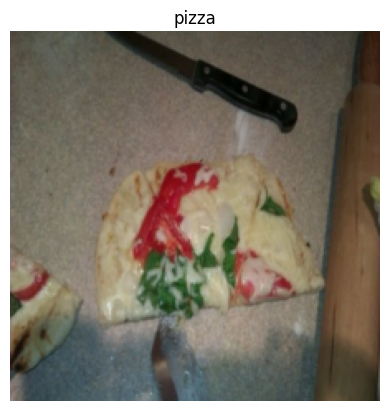

In [31]:
#Combined sequence
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[lbl])
plt.axis('off')
print(f"Original image shape: {img.shape}")

# Turn image into features maps
img_out_of_conv2d = conv2d_layer(img.unsqueeze(dim=0))
print(f"Image shape after conv2d layer: {img_out_of_conv2d.shape}")

# Flatten the feature maps
print(f"Image shape after flattening: {img_out_of_conv2d_flatten.shape}")

In [32]:
# Reshape dimensions through permute
img_out_of_conv2d_flatten_reshaped = img_out_of_conv2d_flatten.permute(0,2,1)
print(f"Image shape after reshaping: {img_out_of_conv2d_flatten_reshaped.shape}")

Image shape after reshaping: torch.Size([1, 196, 768])


Text(0.5, 1.0, 'Flatten feature map shape: torch.Size([1, 196])')

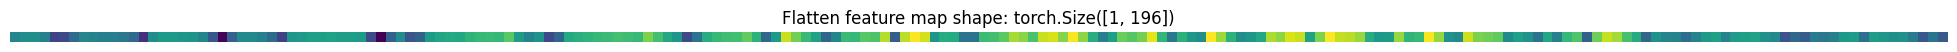

In [33]:
# Single flattened feature map where index: (batch_size, number_of_patches, embedding_dimension)
fig_single_flattened_feat_map = img_out_of_conv2d_flatten_reshaped[:, :, 0]

# Show the map
plt.figure(figsize=(25, 25))
plt.imshow(fig_single_flattened_feat_map.detach().numpy())
plt.axis('off')
plt.title(f"Flatten feature map shape: {fig_single_flattened_feat_map.shape}")


### 4.5 Turning the ViT patch embedding layer into a PyTorch module

In [34]:
# 1. Creating a class which is inherited from nn.Module
class PatchEmbeddingClass(nn.Module):
  # 2. Initalize the layer with appripriate hyperparameters
  def __init__(
       self, in_channels:int=2,
       patch_size:int=16,
       embedding_dim:int=768):
    super().__init__()
    #3. Conv2nd layer that turns image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    #4. Layer that flattens the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    #5. Forward method for computation steps
  def forward(self, x):
    # Assert to check if input is correct shape
    img_resol = x.shape[-1]
    assert img_resol % patch_size == 0, f"Image size ({img_resol}) must be divisible by patch size ({patch_size})"
    # perform forward step
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Permute the image into correct shape
    # Need to adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    return x_flattened.permute(0, 2, 1)

In [35]:
# Test class above
#Set rand seed so it matches the example
set_rand_seed.set_rand_seed()

#Instance of patch embedding layer
patch_embedding_layer = PatchEmbeddingClass(in_channels=3,
                                            patch_size=16,
                                            embedding_dim=768)
print(f"Input image shape: {img.unsqueeze(0).shape}")
patch_embedding_layer_image = patch_embedding_layer(img.unsqueeze(0))
print(f"Output image shape: {patch_embedding_layer_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output image shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding

In [36]:
# Getting the batch size and embedding dimension
batch_size = patch_embedding_layer_image.shape[0]
embedding_dim = patch_embedding_layer_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
#[batch_size, number_of_tokens, D]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim, requires_grad=True))

# Check the first 10 examples of the class_token
print(f"First 10 examples of class token: \n{class_token[:10]}")

# Show the class_token shape
print(f"Class token shape: {class_token.shape} -> batch_size, number_of_tokens, embedding_dimension")


First 10 examples of class token: 
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1.,

In [37]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_img_with_class_embedding = torch.cat((class_token, patch_embedding_layer_image), dim=1)

# Check teh sequence of patch embeddings with the prepend class token embedding
print(f"Patch embdedded image with class embedding: \n{patch_embedded_img_with_class_embedding}")
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_img_with_class_embedding.shape} -> batch_size, number_of_patches, embedding dimension")

Patch embdedded image with class embedding: 
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3625,  0.0826, -0.1179,  ...,  0.2491, -0.1314,  0.1234],
         [-0.3760,  0.0979, -0.1319,  ...,  0.2805, -0.1595,  0.1435],
         ...,
         [-0.2838,  0.0014, -0.0773,  ...,  0.2162, -0.1525,  0.1160],
         [-0.3027,  0.0510, -0.1190,  ...,  0.1994, -0.1147,  0.1282],
         [-0.2224,  0.0553, -0.0909,  ...,  0.1485, -0.0972,  0.1443]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> batch_size, number_of_patches, embedding dimension


### 4.7 Creating the position embedding

In [38]:
# View the sequence of patch embeddings with the prepend class embedding
patch_embedded_img_with_class_embedding, patch_embedded_img_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3625,  0.0826, -0.1179,  ...,  0.2491, -0.1314,  0.1234],
          [-0.3760,  0.0979, -0.1319,  ...,  0.2805, -0.1595,  0.1435],
          ...,
          [-0.2838,  0.0014, -0.0773,  ...,  0.2162, -0.1525,  0.1160],
          [-0.3027,  0.0510, -0.1190,  ...,  0.1994, -0.1147,  0.1282],
          [-0.2224,  0.0553, -0.0909,  ...,  0.1485, -0.0972,  0.1443]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [39]:
# Check and calculate N (number of patches)
number_of_patches = int((height * width)/patch_size**2)

# Get embedding dimension
embedding_dim = patch_embedded_img_with_class_embedding.shape[2]

# Create learnable 1D position embedding
pos_embed = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dim), requires_grad=True)

# Check first 10 sequences and 10 position embedding values and shape of the position embedding)
print(f"First 10 sequences of position embedding: \n{pos_embed[0, :10, :10]}")
print(f"Position embedding shape: {pos_embed.shape} -> batch_size, number_of_patches, embedding_dimension")

First 10 sequences of position embedding: 
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> batch_size, number_of_patches, embedding_dimension


In [40]:
# Add the position embedding to the patch and class token embedding
patch_and_pos_emb = patch_embedded_img_with_class_embedding + pos_embed
print(f"Patch and position embdedding: {patch_and_pos_emb}")
print(f"Shape of patch and position embedding: {patch_and_pos_emb.shape} - > batch_size, number_of_patches, embedding_dimension")

Patch and position embdedding: tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6375, 1.0826, 0.8821,  ..., 1.2491, 0.8686, 1.1234],
         [0.6240, 1.0979, 0.8681,  ..., 1.2805, 0.8405, 1.1435],
         ...,
         [0.7162, 1.0014, 0.9227,  ..., 1.2162, 0.8475, 1.1160],
         [0.6973, 1.0510, 0.8810,  ..., 1.1994, 0.8853, 1.1282],
         [0.7776, 1.0553, 0.9091,  ..., 1.1485, 0.9028, 1.1443]]],
       grad_fn=<AddBackward0>)
Shape of patch and position embedding: torch.Size([1, 197, 768]) - > batch_size, number_of_patches, embedding_dimension


### 4.8 Putting it all together: from image to embedding

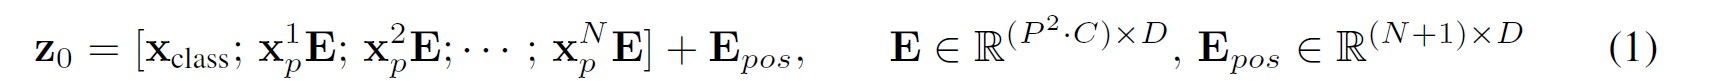

In [41]:
# 1. We use the same patch size of 16
# 2. Check the shape of original image and get its dimensions
print(f"Image tensor shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

# 3. Get image tensor and add batch dimension
batch_dim_of_img = img.unsqueeze(dim=0)
print(f"Input image with batch dimension shape: {batch_dim_of_img.shape}")

# 4. Create the patch embedding layer
num_of_colors = 3
embedding_dims = 768
embedding_layer_of_patch = PatchEmbeddingClass(in_channels=num_of_colors,
                                               patch_size=patch_size,
                                               embedding_dim=embedding_dims)

# 5. Pass image through patch embedding layer
embedding_of_patch = embedding_layer_of_patch(batch_dim_of_img)
print(f"Shape of embedding of patch: {embedding_of_patch.shape}")

# 6. Create class token embedding
batch_size = embedding_of_patch.shape[0]
embedding_dimension = embedding_of_patch.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, embedding_of_patch), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1,
                                             embedding_dimension), requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape}")

# 9. Add position embedding to patch embedding
patch_and_pos_emb = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_pos_emb.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Shape of embedding of patch: torch.Size([1, 196, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5.0 Equation 2: The MSA (Multi-head Self Attention) Block
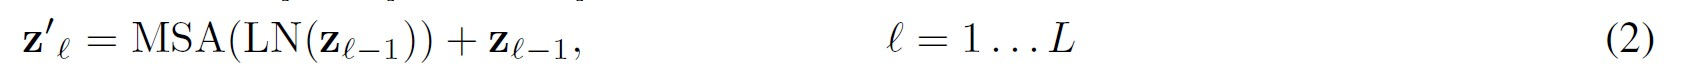

### 5.1 The LayerNorm (LN) layer

In [42]:
class MSABlock(nn.Module):
  """Creates Multi-Head Self-Attention Block aka MSA"""
  # Initation of hyperparameters from Table 1 of the paper
  def __init__(self,
               embed_dim:int=768, #Hidden size D - embedding dimension from Table 1
               num_heads:int= 12, # heads from Table 1 for ViT-Base
               dropout:float=0 # paper doesn't have a number for this param
               ):
      super().__init__()

      # Create the Norm layer NM
      self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

      # Create MSA layer
      self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

  def forward(self, x):
      x = self.layer_norm(x)
      attn_output, _ = self.multihead_attn(
          query=x, # querry embeddings
          key=x, #key embeddings
          value=x, # valuse embeddings
          need_weights=False)
      return attn_output

### 5.2 The MSA layer

In [43]:
# Test 2nd equation
#Create instance MSA block uing default hyperparameters hence not setting them up here
msa_block = MSABlock()
patched_img_through_msa_block = msa_block(patch_and_pos_emb)
print(f"Input shape of MSA block: {patch_and_pos_emb.shape}")
print(f"Output shape of MSA block: {patched_img_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


## 6.0 Equation 3: Multilayer Perceptron (MLP)

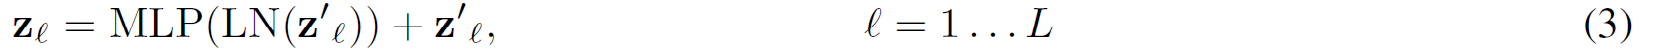


### 6.1 The MLP layer(s)

The structure of our MLP block:

`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`

### 6.2 Replicating Equation 3 with PyTorch layers

In [44]:
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
  # parameters are from Table 1
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(nn.Linear(
            in_features=embedding_dim,
            out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout))

  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [45]:
#Test above
mlp_block = MLPBlock()
patched_img_thru_mlp_block = mlp_block(patched_img_through_msa_block)
print(f"Input shape of MLP Block{patched_img_through_msa_block.shape}")
print(f"Output shape of MLP Block{patched_img_thru_mlp_block.shape}")

Input shape of MLP Blocktorch.Size([1, 197, 768])
Output shape of MLP Blocktorch.Size([1, 197, 768])


## 7.0 Create the Transformer Encoder

`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] ->` ...

### 7.1 Creating a Transformer Encoder by combining our custom made layers

In [46]:
class TransformerEncoderBlock(nn.Module):
  """Creates a transformer encoder block."""
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):
    super().__init__()
    # Instatiate MSA block for equation 2
    self.msa_block = MSABlock(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout)

    # Instantiate MLP block for equation 3
    self.mlp_block = MLPBlock(
        embedding_dim=embedding_dim,
        mlp_size=mlp_size,
        dropout=mlp_dropout)

  def forward(self, x):
    return x + self.mlp_block(x + self.msa_block(x))

In [47]:
# Test block above
transformer_enc_block = TransformerEncoderBlock()

summary(model=transformer_enc_block, input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        col_width=25)

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]             [1, 197, 768]             --                        True
├─MSABlock (msa_block)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention (multihead_attn)         --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock (mlp_block)                             [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential (mlp)                            [1, 19

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
pytorch_transformer_enc_layer = nn.TransformerEncoderLayer(
    d_model=768, # Hidden size D from Table 1
    nhead=12, # Heads from Table 1
    dim_feedforward=3072, # MLP size from Table 1
    dropout=0.1, # Amount of dropout for dense layer from Table 3
    activation="gelu", # GELU non-lenar activation
    batch_first=True, # Do our batches come first
    norm_first=True) # Normalize first after MSA/MLP Layer

## 8.0 Putting it all together to create ViT

In [49]:
# ViT class that combines all together
class ViTclass (nn.Module):
  # Initiating hyperparameters from Table 1
  def __init__(self,
               img_size:int=224, # Table 3
               in_channels:int=3, # Number of colors
               patch_size:int=16,
               num_transform_layers:int=12, # Table 1 form Layers for Vit-Base
               embedding_dim:int=768, # Hidden size D from Table 1
               mlp_size:int=3072, # MLP size from Table 1
               num_heads:int=12, # Heads from Table 1
               attn_dropout:float=0.1, # Amount of dropout for attention from Table 1
               mlp_dropout:int=0.1, #Dropout for dense/MLP Layer
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000, # Default for ImageNet
               ):
    super().__init__()

    # 3. Make sure the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size {img_size}, patch_size{patch_size}"

    # 4. Calculate number of patches to create position embeddings
    # Comes from formula N=HW/P^2 (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # 5. Learnable class embeddings that needs to go the the front of sequence of patch embeddings
    self.class_embedd = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    # 6. Learnable position embedding
    self.pos_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

    # 7. Embedding dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # 8. Patch embedding layer
    self.patch_embedding = PatchEmbeddingClass(
        in_channels=in_channels,
        patch_size=patch_size,
        embedding_dim=embedding_dim)

    # 9. Transformer Encoder blocks
    self.transformer_encoder = nn.Sequential(*[
        TransformerEncoderBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout
        ) for _ in range(num_transform_layers)
    ])

    # 10. Classifier head
    self.classifier_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim, out_features=num_classes))

    # 11. Forward method
  def forward(self, x):
    # 12. get batch size
    batch_size = x.shape[0]
    # 13. Class token embedding that is expanded to match the batch size (equation 1)
    class_token = self.class_embedd.expand(batch_size, -1, -1)
    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding(x)
    # 15. Concatenate class embedding and patch embedding (eq 1)
    x = torch.cat((class_token, x), dim=1) #(batch_size, num_patches+1, embedding_dim)
    # 16. Add position embrdding to patch embedding (eq 1)
    x = self.pos_embedding + x
    # 17. Run embedding dropout (Apendix B.1)
    x = self.embedding_dropout(x)
    # 18. Pass patch, position and class embedding through transformer encoder layer (eq 2 & 3)
    x = self.transformer_encoder(x)
    # 19. Put 0th index logit through classifier (eq 4)
    x = self.classifier_head(x[:, 0]) # runs on each sample in a batch at 0 index

    return x

In [50]:
# test if it works
vit = ViTclass()
vit

ViTclass(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbeddingClass(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MSABlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Tr

In [51]:
set_rand_seed.set_rand_seed()
rand_img_tensor = torch.randn(1, 3, 224, 224)
vit_out = ViTclass(num_classes=len(class_names))
print(f"Output of ViT: {vit_out(rand_img_tensor)}")

Output of ViT: tensor([[0.2647, 0.9022, 1.1738]], grad_fn=<AddmmBackward0>)


### 8.1 Getting a visual summary of our ViT model

In [52]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"],
        col_width=25)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
ViTclass (ViTclass)                                          [32, 3, 224, 224]         [32, 1000]                152,064                   True
├─PatchEmbeddingClass (patch_embedding)                      [32, 3, 224, 224]         [32, 196, 768]            --                        True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]         [32, 768, 14, 14]         590,592                   True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]         [32, 768, 196]            --                        --
├─Dropout (embedding_dropout)                                [32, 197, 768]            [32, 197, 768]            --                        --
├─Sequential (transformer_encoder)                           [32, 197, 768]            [32, 197, 768]            --                    

## 9.0 Setting up training code for our ViT model

### 9.1 Create an optimizer

In [53]:
optimizer_adam = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999), # see page 5, section training & Fine-tuning
                             weight_decay=0.3) # see page 5, section training & Fine-tuning

### 9.2 Create a loss function


In [54]:
cross_entr_loss_fn = nn.CrossEntropyLoss()

### 9.3 Training ViT model

In [55]:
set_rand_seed.set_rand_seed()

model_results = engine.train(model=vit,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             optimizer=optimizer_adam,
                             loss_fn=cross_entr_loss_fn,
                             epochs=10,
                             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7551 | train_acc: 0.3281 | test_loss: 3.2722 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9878 | train_acc: 0.2852 | test_loss: 4.4820 | test_acc: 0.2604
Epoch: 3 | train_loss: 2.0814 | train_acc: 0.4102 | test_loss: 2.3756 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.5237 | train_acc: 0.2969 | test_loss: 1.3572 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3010 | train_acc: 0.2891 | test_loss: 1.3124 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2376 | train_acc: 0.3164 | test_loss: 1.2851 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2891 | train_acc: 0.2773 | test_loss: 1.2101 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1642 | train_acc: 0.2930 | test_loss: 1.2423 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2304 | train_acc: 0.3047 | test_loss: 1.0545 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3122 | train_acc: 0.2617 | test_loss: 1.4103 | test_acc: 0.2604


### 9.4 What training setup is missing

| Hyperparameter value | ViT Paper | My implementation |
|---|---|---|
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M(JFT | 225 |
| Epochs | 7, 90, 300 | 10 |
| Batch size | 4096 | 32
| Learning rate warmap | 10k steps (Table 3) | None
| Learning rate decay | Linear/Cosine (Table 3) | None
| Gradient clipping | Global norm (Table 3) | None

Prevent overfitting:
* Learning rate warmup - gradually increases the learning rate from a very low initial value to a target learning rate over a short initial period of training
* Learning rate decay - adjusts the learning rate during training, as training progresses and model gets closer to an optimal solution the learining rate decreases allowing for finer adjustments and better convergence
* Gradient clipping - prevents gradients from getting too big

### 9.5 Plot the loss curves of the model

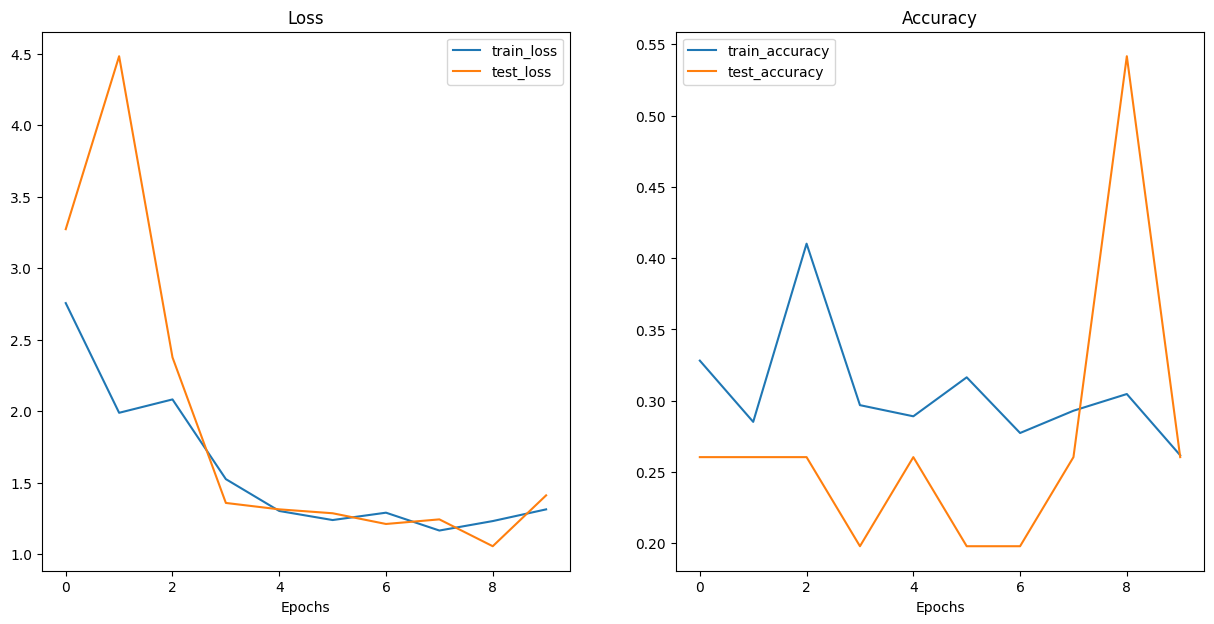

In [56]:
utils.plot_loss_curves(model_results)

## 10.0 Use preptrained ViT from `torchvision.models` on the same dataset

### 10.1 Why use a pretrained model?

The ViT-L/16 model pre-trained on the public ImageNet-21k dataset performs well on most datasets too, while taking fewer resources to pre-train: it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days.

### 10.2 Getting a pretrained ViT model and creating a feature extractor

In [57]:
# 1. get weights
vit_pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# 2. setup model
vit_pretrained_model = torchvision.models.vit_b_16(weights=vit_pretrained_weights).to(device)
# 3. freeze base parameters
for param in vit_pretrained_model.parameters():
  param.requires_grad = False
# 4. change the classifier head
set_rand_seed.set_rand_seed()
vit_pretrained_model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 87.9MB/s]


### 10.3 Preparing data for the pretrained ViT model

In [58]:
# Get automatic transforms from pretrained ViT weights
vit_pretrained_transforms = vit_pretrained_weights.transforms()

In [59]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names_pretrained = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_pretrained_transforms,
    batch_size=32,
    num_workers=os.cpu_count()
)

### 10.4 Train feature extractor ViT model

In [60]:
optimizer_adam_for_pretrained_model = torch.optim.Adam(
    params=vit_pretrained_model.parameters(),
    lr=3e-3
    #betas=(0.9, 0.999), # see page 5, section training & Fine-tuning
    #weight_decay=0.3)
)

cross_entropy_loss_fn_for_pretrained_model = nn.CrossEntropyLoss()

set_rand_seed.set_rand_seed()

model_results_pretrained = engine.train(
    model=vit_pretrained_model,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer_adam_for_pretrained_model,
    loss_fn=cross_entropy_loss_fn_for_pretrained_model,
    epochs=10,
    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5048 | train_acc: 0.8047 | test_loss: 0.2504 | test_acc: 0.9186
Epoch: 2 | train_loss: 0.1301 | train_acc: 0.9609 | test_loss: 0.1858 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.0835 | train_acc: 0.9727 | test_loss: 0.2107 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.0508 | train_acc: 0.9844 | test_loss: 0.2196 | test_acc: 0.8873
Epoch: 5 | train_loss: 0.0312 | train_acc: 0.9922 | test_loss: 0.2100 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.0275 | train_acc: 0.9961 | test_loss: 0.2028 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.0173 | train_acc: 1.0000 | test_loss: 0.2240 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.0134 | train_acc: 1.0000 | test_loss: 0.2217 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.0140 | train_acc: 1.0000 | test_loss: 0.2131 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0102 | train_acc: 1.0000 | test_loss: 0.2040 | test_acc: 0.9176


### 10.5 Plot feature extractor ViT model loss curves

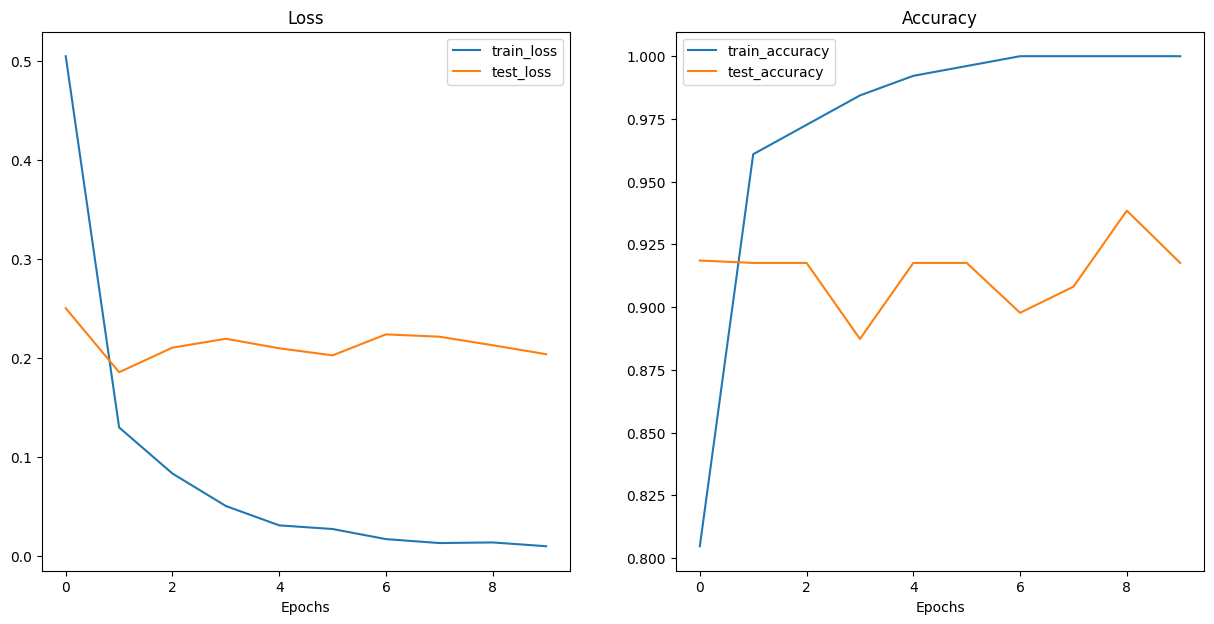

In [61]:
utils.plot_loss_curves(model_results_pretrained)

### 10.6 Save feature extractor ViT model and check file size

In [62]:
# Setup the model filepath
vit_pretrained_model_path = "models"
# Instantiate a new instance of model to load the saved state_dict()
vit_saved_model = utils.save_model(model=vit_pretrained_model,
                                   target_dir=vit_pretrained_model_path,
                                   model_name="08_vit_pretrained__feature_extractor_pizza_16_10_epochs.pth")

[INFO] Saving model to: models/08_vit_pretrained__feature_extractor_pizza_16_10_epochs.pth


In [63]:
# Check the model size
vit_pretrained_model_size = Path("models/08_vit_pretrained__feature_extractor_pizza_16_10_epochs.pth").stat().st_size // (1024*1024)
print(f"ViT pretrained feature extractor model size: {vit_pretrained_model_size} MB")

ViT pretrained feature extractor model size: 327 MB


## 11.0 Make predictions on a custom image

In [64]:
custom_img_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
custom_img_path = Path("data/pizza_dad.jpeg")
if not custom_img_path.is_file():
  with open (custom_img_path, "wb") as f:
    print(f"Donwloading custom image to {custom_img_path}")
    f.write(requests.get(custom_img_url).content)
else:
  print(f"{custom_img_path} already exists")

Donwloading custom image to data/pizza_dad.jpeg


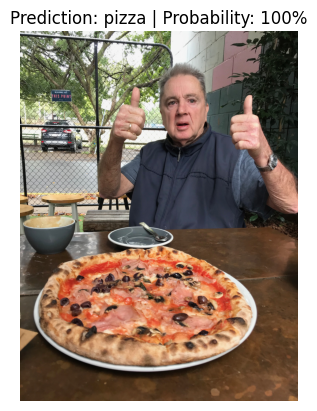

In [66]:
# test the model on custom image
predict.predict_show_image_fn(model=vit_pretrained_model,
                           image_path=custom_img_path,
                           class_names=class_names)